# Flatiron Health mPC: Machine learning models with crude imputation 

**OBJECTIVE: Build 4 survival machine learning models using a crude imputation strategy. This imputation strategy assumes data is missing completely at random and will impute median for numerical variables and leave missing categorical entries as "unknown" (eg., possible ECOG values are 0, 1, 2, 3, 4, 5, and unknown). The machine learning model that performs best in this section will be used in the multiple imputation chained equation notebook.**

**BACKGROUND: The models were built using scikit-survival which is a machine learning library for survival analysis.  All 4 of these machine learning models are intended for survival analysis and so take into account censored data.** 

**The measure used to evaluate model performance is time-dependent area under the receiver operator curve (AUC) at 2 years. This metric determines how well a model can distinguish patients who die by time *t* from patients who die after this time. Our focus is to assess model discriminatory performance within the few couple years from metastatic diagnosis. Time dependent AUC was selected instead of the more frequently used metric in survival data, concordance index, since the concordance index is not time dependent and thus assess models performance over the entire range of survival times which in our case would be over 10 years.** 

**The time point 2 year from metastatic diagnosis was selected as the primary time-point of interest and so all machine learning model hyperparamters are tuned to maximize performance at that time point.**

**OUTLINE:**
1. **Preprocessing**
2. **Gradient boosting model** 
3. **Random survival forest** 
4. **Penalized Cox models**
5. **Linear support vector machine** 

## 1. Preprocessing 

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 

### 1.1 Importing full dataframes

In [2]:
# Import training set and set PatientID as index.
train = pd.read_csv('train_full.csv', index_col = 'PatientID')
print(len(train), train.index.is_unique)

15141 True


In [3]:
# Import test set and set PatientID as index.
test = pd.read_csv('test_full.csv', index_col = 'PatientID')
print(len(test), test.index.is_unique)

3786 True


### 1.2 Converting datatypes 

In [4]:
list(train.select_dtypes(include = ['object']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [5]:
to_be_categorical = list(train.select_dtypes(include = ['object']).columns)

In [6]:
to_be_categorical.append('met_year')

In [7]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    train[x] = train[x].astype('category')

In [8]:
list(train.select_dtypes(include = ['category']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [9]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    test[x] = test[x].astype('category')

In [10]:
# Convert death_status into True or False (required for scikit-survival). 
train['death_status'] = train['death_status'].astype('bool')

In [11]:
# Convert death_status into True or False (required for scikit-survival).
test['death_status'] = test['death_status'].astype('bool')

### 1.3 Defining validation set

**A validation dataset will be constructed from the training set. This validation set will comprise of 25% of the training set. It will be used to assist in early stopping for the gradient boosting survival model and the random survival model. Like in the training-test split, a stratified approach will be carried out to preserve the distribution of diagnosis years.**   

In [12]:
train['met_year_cat'] = pd.cut(train['met_year'],
                               bins = [2012, 2014, 2016, 2018, 2020, 2022],
                               labels = ['13-14', '15-16', '17-18', '19-20', '21-22'])

In [13]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 42)

for sub_train_index, val_index in sss.split(train, train['met_year_cat']):
    sub_train = train.iloc[sub_train_index]
    val = train.iloc[val_index]

In [14]:
train = train.drop(columns = ['met_year_cat'])

In [15]:
sub_train = sub_train.drop(columns = ['met_year_cat'])

In [16]:
val = val.drop(columns = ['met_year_cat'])

In [17]:
pd.DataFrame(val.index, columns = ['PatientID']).to_csv('val_IDs.csv', index = False, header = True)

In [18]:
val_IDs = pd.read_csv('val_IDs.csv')

### 1.4 Separate into X and Y

In [19]:
# 'X' datasets
train_x = train.drop(columns = ['death_status', 'timerisk_activity']) #80% of data 

test_x = test.drop(columns = ['death_status', 'timerisk_activity']) #20% of data 

sub_train_x = sub_train.drop(columns = ['death_status', 'timerisk_activity']) #60% of data

val_x = val.drop(columns = ['death_status', 'timerisk_activity']) #20% of data 

In [20]:
# 'Y' datasets
# Death status and time until event needs to be stored as a structured array to be compatible with scikit-survival
y_dtypes = train[['death_status', 'timerisk_activity']].dtypes

train_y = np.array([tuple(x) for x in train[['death_status', 'timerisk_activity']].values], 
                   dtype = list(zip(y_dtypes.index, y_dtypes)))

test_y = np.array([tuple(x) for x in test[['death_status', 'timerisk_activity']].values], 
                  dtype = list(zip(y_dtypes.index, y_dtypes)))

sub_train_y = np.array([tuple(x) for x in sub_train[['death_status', 'timerisk_activity']].values],
                       dtype = list(zip(y_dtypes.index, y_dtypes)))

val_y = np.array([tuple(x) for x in val[['death_status', 'timerisk_activity']].values],
                 dtype = list(zip(y_dtypes.index, y_dtypes)))

### 1.5 Build pipeline

In [21]:
list(train_x.select_dtypes(exclude = ['category']).columns)

['age',
 'PSADiagnosis',
 'PSAMetDiagnosis',
 'delta_met_diagnosis',
 'crpc',
 'crpc_time',
 'psa_diag_na',
 'psa_met_na',
 'steroid_diag',
 'opioid_PO_diag',
 'nonopioid_PO_diag',
 'pain_IV_diag',
 'ac_diag',
 'antiinfective_IV_diag',
 'antiinfective_diag',
 'antihyperglycemic_diag',
 'ppi_diag',
 'antidepressant_diag',
 'bta_diag',
 'thyroid_diag',
 'medicare',
 'medicaid',
 'medicare_medicaid',
 'commercial',
 'patient_assistance',
 'other_govt',
 'self_pay',
 'other',
 'weight_diag',
 'bmi_diag',
 'bmi_diag_na',
 'weight_pct_change',
 'weight_pct_na',
 'weight_slope',
 'albumin_diag',
 'alp_diag',
 'alt_diag',
 'ast_diag',
 'bicarb_diag',
 'bun_diag',
 'calcium_diag',
 'chloride_diag',
 'creatinine_diag',
 'hemoglobin_diag',
 'neutrophil_count_diag',
 'platelet_diag',
 'potassium_diag',
 'sodium_diag',
 'total_bilirubin_diag',
 'wbc_diag',
 'albumin_diag_na',
 'alp_diag_na',
 'alt_diag_na',
 'ast_diag_na',
 'bicarb_diag_na',
 'bun_diag_na',
 'calcium_diag_na',
 'chloride_diag_na',


In [22]:
# List of numeric variables, excluding binary variables. 
numerical_features = [
    'age',
    'PSADiagnosis',
    'PSAMetDiagnosis',
    'delta_met_diagnosis',
    'crpc_time',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag', 
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'psa_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'alp_max',
    'alt_max',
    'ast_max',
    'bicarb_max',
    'bun_max',
    'calcium_max',
    'chloride_max',
    'creatinine_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'psa_max',
    'sodium_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'alp_min',
    'alt_min',
    'ast_min',
    'bicarb_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'hemoglobin_min',
    'neutrophil_count_min',
    'platelet_min',
    'potassium_min',
    'psa_min',
    'sodium_min',
    'total_bilirubin_min',
    'wbc_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'psa_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'psa_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'icd_count']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [23]:
list(train_x.select_dtypes(include = ['category']).columns)

['Gender',
 'race',
 'ethnicity',
 'p_type',
 'NStage',
 'MStage',
 'Histology',
 'GleasonScore',
 'stage',
 'met_year',
 'brca_status',
 'ecog_diagnosis',
 'prim_treatment']

In [24]:
# List of categorical features.
categorical_features = list(train_x.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [25]:
# Remaining unprocessed columns which are binary variables
len(train_x.columns) - (len(numerical_features) + len(categorical_features))

101

In [26]:
all_columns = list(train_x.columns)

In [27]:
# Prints number of columns after removing columns that are numerical or categorical. 
for i in list(numerical_features + categorical_features):
    all_columns.remove(i)
len(all_columns)

101

In [28]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

## 2. Gradient boosting survival model

In [29]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingGridSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from joblib import dump, load 

import matplotlib.pyplot as plt

import warnings 

**The gradient boosting survival model will be configured by setting a low learning rate (eg., <= 0.1) and choosing the number of trees by monitoring the 3 year AUC on the valdiation dataset and stopping once performance on the validation dataset begins to degrade. The learning rate will be tuned to achieve a target tree size >500. Once learning rate and tree number are set, a halving grid search with 3-fold cross validation will be performed to identify ideal max depth and subsample percentage.**  

### 2.1 Determining number of trees for full model 

**The full model includes all variables, notably about 100 summary labs values which have significant missingness (>40%).**

In [30]:
sub_train_xt = preprocessor.fit_transform(sub_train_x)
val_xt = preprocessor.transform(val_x)

gbm_exp = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                           learning_rate = 0.05,
                                           max_depth = 3,
                                           subsample = 0.75,
                                           verbose = 1,
                                           random_state = 42)

gbm_exp.fit(sub_train_xt, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       36052.3243           6.7078           38.97m
         2       36042.2369           7.0135           38.91m
         3       36023.5165           6.3039           38.90m
         4       35780.7650           6.8189           38.94m
         5       35827.5751           6.5231           38.95m
         6       35825.0863           5.6365           38.89m
         7       35901.5510           5.6746           38.86m
         8       35702.4604           5.1060           38.82m
         9       35629.3775           5.1060           38.78m
        10       35492.4929           5.3778           38.74m
        20       35738.7938           3.6829           38.80m
        30       35461.2710           2.6952           38.44m
        40       35504.6955           1.9365           38.22m
        50       35183.7451           2.0966           37.96m
        60       35432.2523           1.2272           37.65m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [31]:
gbm_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] 
                  for risk_score in gbm_exp.staged_predict(val_xt)]

In [32]:
gbm_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] 
                     for risk_score in gbm_exp.staged_predict(sub_train_xt)]

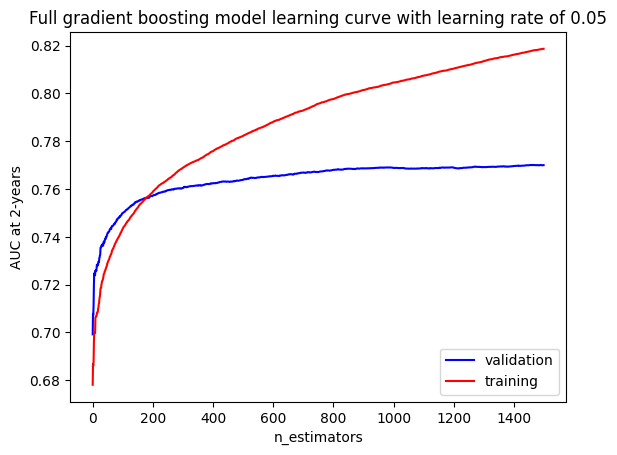

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm_staged_auc))
plt.plot(x, gbm_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Full gradient boosting model learning curve with learning rate of 0.05')

plt.show()

In [34]:
# Average AUC for every 25 additional trees. 
mean_auc_list = []
for x in np.arange(0, len(gbm_staged_auc), 25):
    mean_auc_list.append(np.mean(gbm_staged_auc[x:x+24]))

In [35]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm_staged_auc[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm_staged_auc_tr[np.where(np.diff(mean_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 975
Validation dataset AUC before degrading: 0.7689795767536498
Training dataset AUC before degrading: 0.8036036534153534


### 2.2 Determining number of trees for sparse model 

**The sparse model includes a subset of the summary lab values that are considered clinically relevant. Performance will be compared to the full model.**

In [30]:
all_labs = [
    'PSADiagnosis',
    'PSAMetDiagnosis',
    'psa_diag_na',
    'psa_met_na',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'albumin_diag_na',
    'alp_diag_na',
    'alt_diag_na',
    'ast_diag_na',
    'bicarb_diag_na',
    'bun_diag_na',
    'calcium_diag_na',
    'chloride_diag_na',
    'creatinine_diag_na',
    'hemoglobin_diag_na',
    'neutrophil_count_diag_na',
    'platelet_diag_na',
    'potassium_diag_na',
    'sodium_diag_na',
    'total_bilirubin_diag_na',
    'wbc_diag_na',
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'psa_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'alp_max',
    'alt_max',
    'ast_max',
    'bicarb_max',
    'bun_max',
    'calcium_max',
    'chloride_max',
    'creatinine_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'psa_max',
    'sodium_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'alp_min',
    'alt_min',
    'ast_min',
    'bicarb_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'hemoglobin_min',
    'neutrophil_count_min',
    'platelet_min',
    'potassium_min',
    'psa_min',
    'sodium_min',
    'total_bilirubin_min',
    'wbc_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'psa_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'psa_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'psa_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [31]:
keep_labs = [
    'PSADiagnosis',
    'PSAMetDiagnosis',
    'psa_diag_na',
    'psa_met_na',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'albumin_diag_na',
    'alp_diag_na',
    'alt_diag_na',
    'ast_diag_na',
    'bicarb_diag_na',
    'bun_diag_na',
    'calcium_diag_na',
    'chloride_diag_na',
    'creatinine_diag_na',
    'hemoglobin_diag_na',
    'neutrophil_count_diag_na',
    'platelet_diag_na',
    'potassium_diag_na',
    'sodium_diag_na',
    'total_bilirubin_diag_na',
    'wbc_diag_na',
    'alp_max',
    'alt_max',
    'ast_max',
    'calcium_max',
    'creatinine_max',
    'psa_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min',
    'psa_slope',
    'psa_slope_na']

In [32]:
drop_labs = [
    'albumin_avg',
    'alp_avg',
    'alt_avg',
    'ast_avg',
    'bicarb_avg',
    'bun_avg',
    'calcium_avg',
    'chloride_avg',
    'creatinine_avg',
    'hemoglobin_avg',
    'neutrophil_count_avg',
    'platelet_avg',
    'potassium_avg',
    'psa_avg',
    'sodium_avg',
    'total_bilirubin_avg',
    'wbc_avg',
    'albumin_max',
    'bicarb_max',
    'bun_max',
    'chloride_max',
    'hemoglobin_max',
    'neutrophil_count_max',
    'platelet_max',
    'potassium_max',
    'sodium_max',
    'alp_min',
    'alt_min',
    'ast_min',
    'bun_min',
    'calcium_min',
    'chloride_min',
    'creatinine_min',
    'neutrophil_count_min',
    'potassium_min',
    'psa_min',
    'total_bilirubin_min',
    'albumin_std',
    'alp_std',
    'alt_std',
    'ast_std',
    'bicarb_std',
    'bun_std',
    'calcium_std',
    'chloride_std',
    'creatinine_std',
    'hemoglobin_std',
    'neutrophil_count_std',
    'platelet_std',
    'potassium_std',
    'psa_std',
    'sodium_std',
    'total_bilirubin_std',
    'wbc_std',
    'albumin_slope',
    'alp_slope',
    'alt_slope',
    'ast_slope',
    'bicarb_slope',
    'bun_slope',
    'calcium_slope',
    'chloride_slope',
    'creatinine_slope',
    'hemoglobin_slope',
    'neutrophil_count_slope',
    'platelet_slope',
    'potassium_slope',
    'sodium_slope',
    'total_bilirubin_slope',
    'wbc_slope',
    'albumin_slope_na',
    'alp_slope_na',
    'alt_slope_na',
    'ast_slope_na',
    'bicarb_slope_na',
    'bun_slope_na',
    'calcium_slope_na',
    'chloride_slope_na',
    'creatinine_slope_na',
    'hemoglobin_slope_na',
    'neutrophil_count_slope_na',
    'platelet_slope_na',
    'potassium_slope_na',
    'sodium_slope_na',
    'total_bilirubin_slope_na',
    'wbc_slope_na']

In [33]:
len(keep_labs) + len(drop_labs) == len(all_labs)

True

In [34]:
sub_train_x_red = sub_train_x.drop(columns = drop_labs)
val_x_red = val_x.drop(columns = drop_labs)

In [35]:
print(sub_train_x.shape)
print(sub_train_x_red.shape)
print(val_x.shape)
print(val_x_red.shape)

(11355, 225)
(11355, 139)
(3786, 225)
(3786, 139)


In [36]:
sub_train_x_red.loc[:, 'alp_max_na'] = np.where(sub_train_x_red['alp_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'alt_max_na'] = np.where(sub_train_x_red['alt_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'ast_max_na'] = np.where(sub_train_x_red['ast_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'calcium_max_na'] = np.where(sub_train_x_red['calcium_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'creatinine_max_na'] = np.where(sub_train_x_red['creatinine_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'psa_max_na'] = np.where(sub_train_x_red['psa_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(sub_train_x_red['total_bilirubin_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'wbc_max_na'] = np.where(sub_train_x_red['wbc_max'].isna(), 1, 0)
sub_train_x_red.loc[:, 'albumin_min_na'] = np.where(sub_train_x_red['albumin_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'bicarb_min_na'] = np.where(sub_train_x_red['bicarb_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'hemoglobin_min_na'] = np.where(sub_train_x_red['hemoglobin_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'platelet_min_na'] = np.where(sub_train_x_red['platelet_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'sodium_min_na'] = np.where(sub_train_x_red['sodium_min'].isna(), 1, 0)
sub_train_x_red.loc[:, 'wbc_min_na'] = np.where(sub_train_x_red['wbc_min'].isna(), 1, 0)

In [37]:
val_x_red.loc[:, 'alp_max_na'] = np.where(val_x_red['alp_max'].isna(), 1, 0)
val_x_red.loc[:, 'alt_max_na'] = np.where(val_x_red['alt_max'].isna(), 1, 0)
val_x_red.loc[:, 'ast_max_na'] = np.where(val_x_red['ast_max'].isna(), 1, 0)
val_x_red.loc[:, 'calcium_max_na'] = np.where(val_x_red['calcium_max'].isna(), 1, 0)
val_x_red.loc[:, 'creatinine_max_na'] = np.where(val_x_red['creatinine_max'].isna(), 1, 0)
val_x_red.loc[:, 'psa_max_na'] = np.where(val_x_red['psa_max'].isna(), 1, 0)
val_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(val_x_red['total_bilirubin_max'].isna(), 1, 0)
val_x_red.loc[:, 'wbc_max_na'] = np.where(val_x_red['wbc_max'].isna(), 1, 0)
val_x_red.loc[:, 'albumin_min_na'] = np.where(val_x_red['albumin_min'].isna(), 1, 0)
val_x_red.loc[:, 'bicarb_min_na'] = np.where(val_x_red['bicarb_min'].isna(), 1, 0)
val_x_red.loc[:, 'hemoglobin_min_na'] = np.where(val_x_red['hemoglobin_min'].isna(), 1, 0)
val_x_red.loc[:, 'platelet_min_na'] = np.where(val_x_red['platelet_min'].isna(), 1, 0)
val_x_red.loc[:, 'sodium_min_na'] = np.where(val_x_red['sodium_min'].isna(), 1, 0)
val_x_red.loc[:, 'wbc_min_na'] = np.where(val_x_red['wbc_min'].isna(), 1, 0)

In [38]:
# List of numeric variables, excluding binary variables. 
numerical_features_red = [
    'age',
    'PSADiagnosis',
    'PSAMetDiagnosis',
    'delta_met_diagnosis',
    'crpc_time',
    'weight_diag',
    'bmi_diag',
    'weight_pct_change',
    'weight_slope',
    'albumin_diag',
    'alp_diag',
    'alt_diag',
    'ast_diag',
    'bicarb_diag',
    'bun_diag',
    'calcium_diag',
    'chloride_diag',
    'creatinine_diag',
    'hemoglobin_diag',
    'neutrophil_count_diag',
    'platelet_diag',
    'potassium_diag',
    'sodium_diag',
    'total_bilirubin_diag',
    'wbc_diag',
    'alp_max',
    'alt_max',
    'ast_max',
    'calcium_max',
    'creatinine_max',
    'psa_max',
    'total_bilirubin_max',
    'wbc_max',
    'albumin_min',
    'bicarb_min',
    'hemoglobin_min',
    'platelet_min',
    'sodium_min',
    'wbc_min',
    'psa_slope',
    'icd_count']

# Transformer will impute column medians and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [39]:
preprocessor_red = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features_red),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [40]:
print(sub_train_x_red.shape)
print(sub_train_y.shape)
print(val_x_red.shape)
print(val_y.shape)

(11355, 153)
(11355,)
(3786, 153)
(3786,)


In [47]:
sub_train_xt_red = preprocessor_red.fit_transform(sub_train_x_red)
val_xt_red = preprocessor_red.transform(val_x_red)

gbm_exp2 = GradientBoostingSurvivalAnalysis(n_estimators = 1500,
                                           learning_rate = 0.05,
                                           max_depth = 3,
                                           subsample = 0.75,
                                           verbose = 1,
                                           random_state = 42)

gbm_exp2.fit(sub_train_xt_red, sub_train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       36052.1591           6.9797           38.24m
         2       36041.9599           6.9973           38.20m
         3       36023.4047           6.4456           38.17m
         4       35780.7706           6.7677           38.17m
         5       35827.7556           6.5059           38.12m
         6       35825.3346           5.4866           38.09m
         7       35901.4715           5.9175           38.06m
         8       35703.2752           5.1992           38.05m
         9       35629.5016           5.0941           38.03m
        10       35493.3167           5.3546           38.03m
        20       35740.0339           3.7025           37.78m
        30       35460.4627           2.7059           37.50m
        40       35505.8487           1.9567           37.23m
        50       35186.0121           2.1027           36.97m
        60       35434.2552           1.1424           36.71m
       

GradientBoostingSurvivalAnalysis(learning_rate=0.05, n_estimators=1500,
                                 random_state=42, subsample=0.75, verbose=1)

In [48]:
gbm2_staged_auc = [cumulative_dynamic_auc(sub_train_y, val_y, risk_score, 730)[0][0] for 
                   risk_score in gbm_exp2.staged_predict(val_xt_red)]

In [49]:
gbm2_staged_auc_tr = [cumulative_dynamic_auc(sub_train_y, sub_train_y, risk_score, 730)[0][0] for 
                      risk_score in gbm_exp2.staged_predict(sub_train_xt_red)]

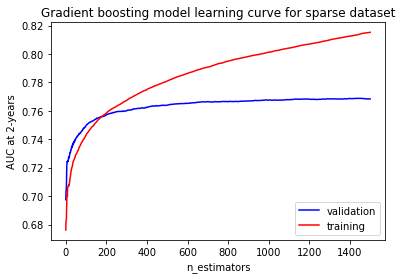

In [50]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = range(len(gbm2_staged_auc))
plt.plot(x, gbm2_staged_auc, color = 'blue', label = 'validation')
plt.plot(x, gbm2_staged_auc_tr, color = 'red', label = 'training')
plt.legend(loc = 'lower right')

plt.xlabel("n_estimators")
plt.ylabel("AUC at 2-years")
plt.title('Gradient boosting model learning curve for sparse dataset')

plt.show()

In [51]:
# Average AUC for every 25 additional trees. 
mean2_auc_list = []
for x in np.arange(0, len(gbm2_staged_auc), 25):
    mean2_auc_list.append(np.mean(gbm2_staged_auc[x:x+24]))

In [52]:
print('Number of trees where 2 year AUC on validation dataset beings to downgrade:', np.where(np.diff(mean2_auc_list) < 0)[0][0]*25)
print('Validation dataset AUC before degrading:', gbm2_staged_auc[np.where(np.diff(mean2_auc_list) < 0)[0][0]*25])
print('Training dataset AUC before degrading:', gbm2_staged_auc_tr[np.where(np.diff(mean2_auc_list) < 0)[0][0]*25])

Number of trees where 2 year AUC on validation dataset beings to downgrade: 675
Validation dataset AUC before degrading: 0.7663947845328447
Training dataset AUC before degrading: 0.7899855643774464


**Performance of the sparse model appears about equivalent to the full model in regards to discriminatory performance on the validation set. The advantages of using the sparse model include less risk of overfitting of training set, faster computational speed, and improved interpretability of feature importance. In addition, there might be improved imputations of missing values with MICE. For these reasons, we'll plan to proceed with the sparse model.**

### 2.3 Further tuning of tree hyperparameters

**Tree depth and subsample will be tuned using a halving grid search with 3-fold cross validation. The other main tree hyperparameter is the minimum sample size in a terminal node (ie., leaf), but since we're using short trees it's unlikely to have significant impact on performance and so we'll omit from the parameter search to save computing time.** 

**Performing a traditional cartesian grid search for gradient boosting model tree hyperparameters is computationally challengng. A halving grid search approach is selected instead since it is much faster. The major drawback of the halving grid search is that good configurations that are slow to converge at the beginning will be pruned prematurely so you can’t be entirely ensure that you’ve identified the best hyperparameters.**  

**As you can see below, our parameter search space is very small. This is because even with a halving grid search it takes considerable time to build models on this dataset.** 

In [41]:
train_x_red = train_x.drop(columns = drop_labs)

In [42]:
train_x_red.loc[:, 'alp_max_na'] = np.where(train_x_red['alp_max'].isna(), 1, 0)
train_x_red.loc[:, 'alt_max_na'] = np.where(train_x_red['alt_max'].isna(), 1, 0)
train_x_red.loc[:, 'ast_max_na'] = np.where(train_x_red['ast_max'].isna(), 1, 0)
train_x_red.loc[:, 'calcium_max_na'] = np.where(train_x_red['calcium_max'].isna(), 1, 0)
train_x_red.loc[:, 'creatinine_max_na'] = np.where(train_x_red['creatinine_max'].isna(), 1, 0)
train_x_red.loc[:, 'psa_max_na'] = np.where(train_x_red['psa_max'].isna(), 1, 0)
train_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(train_x_red['total_bilirubin_max'].isna(), 1, 0)
train_x_red.loc[:, 'wbc_max_na'] = np.where(train_x_red['wbc_max'].isna(), 1, 0)
train_x_red.loc[:, 'albumin_min_na'] = np.where(train_x_red['albumin_min'].isna(), 1, 0)
train_x_red.loc[:, 'bicarb_min_na'] = np.where(train_x_red['bicarb_min'].isna(), 1, 0)
train_x_red.loc[:, 'hemoglobin_min_na'] = np.where(train_x_red['hemoglobin_min'].isna(), 1, 0)
train_x_red.loc[:, 'platelet_min_na'] = np.where(train_x_red['platelet_min'].isna(), 1, 0)
train_x_red.loc[:, 'sodium_min_na'] = np.where(train_x_red['sodium_min'].isna(), 1, 0)
train_x_red.loc[:, 'wbc_min_na'] = np.where(train_x_red['wbc_min'].isna(), 1, 0)

In [43]:
train_x_red.shape

(15141, 153)

In [44]:
# Find all pipe item unique keys 
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 675,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

estimator = as_cumulative_dynamic_auc_scorer(pipe, times = [730])

sorted(estimator.get_params().keys())

['estimator',
 'estimator__columntransformer',
 'estimator__columntransformer__cat',
 'estimator__columntransformer__cat__categories',
 'estimator__columntransformer__cat__drop',
 'estimator__columntransformer__cat__dtype',
 'estimator__columntransformer__cat__handle_unknown',
 'estimator__columntransformer__cat__sparse',
 'estimator__columntransformer__n_jobs',
 'estimator__columntransformer__num',
 'estimator__columntransformer__num__imputer',
 'estimator__columntransformer__num__imputer__add_indicator',
 'estimator__columntransformer__num__imputer__copy',
 'estimator__columntransformer__num__imputer__fill_value',
 'estimator__columntransformer__num__imputer__missing_values',
 'estimator__columntransformer__num__imputer__strategy',
 'estimator__columntransformer__num__imputer__verbose',
 'estimator__columntransformer__num__memory',
 'estimator__columntransformer__num__std_scaler',
 'estimator__columntransformer__num__std_scaler__copy',
 'estimator__columntransformer__num__std_scaler_

In [45]:
pipe = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 675,
                                                                        learning_rate = 0.05,
                                                                        random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__gradientboostingsurvivalanalysis__max_depth': [2, 3, 4], 
              'estimator__gradientboostingsurvivalanalysis__subsample': [0.5, 0.75, 0.9]}

gbm_search = HalvingGridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
gbm_search.fit(train_x_red, train_y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1892
max_resources_: 15141
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 1892
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 5
n_resources: 3784
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 7568
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 15136
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                    estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('num',
                                                                                                                           Pipeline(steps=[('imputer',
                                                                                                                                            SimpleImputer(strategy='median')),
                                                                                                                                           ('std_scaler',
                                                               

In [46]:
gbm_search.best_params_

{'estimator__gradientboostingsurvivalanalysis__max_depth': 4,
 'estimator__gradientboostingsurvivalanalysis__subsample': 0.5}

In [59]:
gbm_search_results = pd.DataFrame(gbm_search.cv_results_)

In [60]:
gbm_search_results.sort_values(by = 'rank_test_score').head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__gradientboostingsurvivalanalysis__max_depth,param_estimator__gradientboostingsurvivalanalysis__subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
14,2,7568,210.736676,0.748582,0.038093,0.000386,4,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.763885,0.744339,0.765844,0.758023,0.009709,1,0.841844,0.857272,0.849418,0.849512,0.006299
18,3,15136,860.166331,0.852606,0.074444,0.008010,4,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.754978,0.743807,0.765191,0.754658,0.008733,2,0.821387,0.825864,0.816560,0.821270,0.003799
15,2,7568,205.120099,0.784350,0.035229,0.001259,2,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.759351,0.743469,0.759237,0.754019,0.007460,3,0.773100,0.795912,0.789931,0.786314,0.009658
16,2,7568,213.728317,19.119882,0.031645,0.001227,3,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.759430,0.742345,0.759126,0.753633,0.007983,4,0.806061,0.824413,0.815499,0.815324,0.007493
17,3,15136,849.085305,0.722532,0.049199,0.000879,2,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.751185,0.737340,0.755904,0.748143,0.007878,5,0.772333,0.775448,0.768160,0.771980,0.002986
6,0,1892,11.174587,0.058181,0.016343,0.002161,4,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.726193,0.725354,0.749968,0.733838,0.011411,6,0.934661,0.934255,0.923795,0.930904,0.005029
9,1,3784,50.061074,0.400851,0.023748,0.002568,3,0.9,{'estimator__gradientboostingsurvivalanalysis_...,0.728935,0.717994,0.749014,0.731981,0.012846,7,0.846299,0.857002,0.843215,0.848839,0.005908
3,0,1892,10.762489,0.092642,0.014150,0.001899,3,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.724001,0.724666,0.747120,0.731929,0.010745,8,0.896157,0.892914,0.882415,0.890495,0.005865
0,0,1892,9.899427,0.063448,0.015136,0.005296,2,0.5,{'estimator__gradientboostingsurvivalanalysis_...,0.728709,0.723586,0.740626,0.730974,0.007139,9,0.846358,0.846951,0.830602,0.841304,0.007571
1,0,1892,10.496567,0.075003,0.010923,0.000073,2,0.75,{'estimator__gradientboostingsurvivalanalysis_...,0.729709,0.728325,0.734667,0.730900,0.002723,10,0.842544,0.846337,0.829358,0.839413,0.007277


### 2.4 Building and evaluating final model 

In [61]:
test_x_red = test_x.drop(columns = drop_labs)

In [62]:
test_x_red.loc[:, 'alp_max_na'] = np.where(test_x_red['alp_max'].isna(), 1, 0)
test_x_red.loc[:, 'alt_max_na'] = np.where(test_x_red['alt_max'].isna(), 1, 0)
test_x_red.loc[:, 'ast_max_na'] = np.where(test_x_red['ast_max'].isna(), 1, 0)
test_x_red.loc[:, 'calcium_max_na'] = np.where(test_x_red['calcium_max'].isna(), 1, 0)
test_x_red.loc[:, 'creatinine_max_na'] = np.where(test_x_red['creatinine_max'].isna(), 1, 0)
test_x_red.loc[:, 'psa_max_na'] = np.where(test_x_red['psa_max'].isna(), 1, 0)
test_x_red.loc[:, 'total_bilirubin_max_na'] = np.where(test_x_red['total_bilirubin_max'].isna(), 1, 0)
test_x_red.loc[:, 'wbc_max_na'] = np.where(test_x_red['wbc_max'].isna(), 1, 0)
test_x_red.loc[:, 'albumin_min_na'] = np.where(test_x_red['albumin_min'].isna(), 1, 0)
test_x_red.loc[:, 'bicarb_min_na'] = np.where(test_x_red['bicarb_min'].isna(), 1, 0)
test_x_red.loc[:, 'hemoglobin_min_na'] = np.where(test_x_red['hemoglobin_min'].isna(), 1, 0)
test_x_red.loc[:, 'platelet_min_na'] = np.where(test_x_red['platelet_min'].isna(), 1, 0)
test_x_red.loc[:, 'sodium_min_na'] = np.where(test_x_red['sodium_min'].isna(), 1, 0)
test_x_red.loc[:, 'wbc_min_na'] = np.where(test_x_red['wbc_min'].isna(), 1, 0)

In [63]:
test_x_red.shape

(3786, 153)

In [64]:
gbm_crude = make_pipeline(preprocessor_red, GradientBoostingSurvivalAnalysis(n_estimators = 675,
                                                                             learning_rate = 0.05,
                                                                             max_depth = 4,
                                                                             subsample = 0.50,
                                                                             verbose = 1,
                                                                             random_state = 42))

gbm_crude.fit(train_x_red, train_y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       31615.9064          23.1342           31.94m
         2       31134.9843          22.5215           32.01m
         3       31434.6457          20.8253           32.15m
         4       31366.7746          21.1058           32.22m
         5       31518.0865          20.8117           32.45m
         6       30874.6568          20.2819           32.48m
         7       31336.2667          18.8125           32.42m
         8       31556.8299          17.5240           32.35m
         9       31384.0675          16.0684           32.30m
        10       31165.5238          17.5668           32.25m
        20       31130.5155          12.3120           31.55m
        30       31123.3016           8.5859           30.90m
        40       30888.5568           7.5956           30.34m
        50       30463.4473           5.8040           29.81m
        60       30979.8412           3.7974           29.30m
       

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope

In [65]:
gbm_risk_scores_te = gbm_crude.predict(test_x_red)
gbm_auc_te = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', gbm_auc_te)

Test set AUC at 2 years: 0.7596291774652096


In [66]:
gbm_risk_scores_tr = gbm_crude.predict(train_x_red)
gbm_auc_tr = cumulative_dynamic_auc(train_y, train_y, gbm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', gbm_auc_tr)

Training set AUC at 2 years: 0.806805889078845


In [67]:
# Bootstrap 10000 2 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_te), len(gbm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], gbm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [68]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.009419665260847851


In [69]:
# Bootstrap 10000 2 yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(gbm_risk_scores_tr), len(gbm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], gbm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [70]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.004366160062619855


In [71]:
crude_auc_data = {'model': ['gbm_crude'],
                  'auc_2yr_te': [gbm_auc_te],
                  'sem_te': [standard_error_te],
                  'auc_2yr_tr': [gbm_auc_tr],
                  'sem_tr': [standard_error_tr]}

crude_auc_df = pd.DataFrame(crude_auc_data)

In [72]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.759629,0.00942,0.806806,0.004366


In [73]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [74]:
times = np.arange(30, 1810, 30)
crude_gbm_auc_over5 = cumulative_dynamic_auc(train_y, test_y, gbm_risk_scores_te, times)[0]

times_data = {}
values = crude_gbm_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_auc_over5 = pd.DataFrame(times_data, index = ['gbm_crude'])

In [75]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.947724,0.880761,0.857184,0.850783,0.854125,0.846298,0.821203,0.826664,0.819633,0.815961,...,0.756552,0.755286,0.752378,0.754577,0.753897,0.752593,0.756331,0.756346,0.761979,0.758326


In [76]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [77]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes_gbm = numerical_features_red + cat_encoder + pass_through

Total number of features: 200
Number of non-zero features in final model: 194


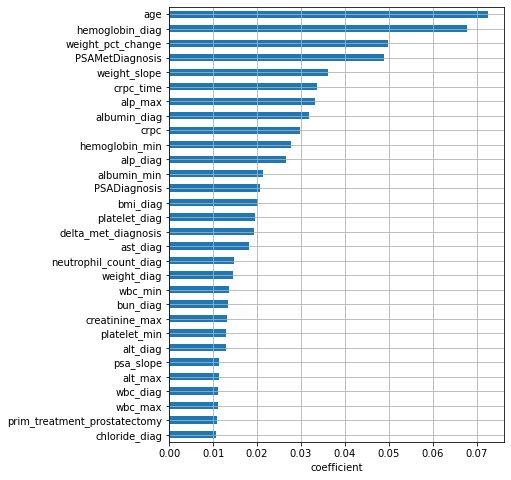

In [78]:
# Dataframe of coefficients for each variable 
coefficients_gbm = pd.DataFrame(
    gbm_crude.named_steps['gradientboostingsurvivalanalysis'].feature_importances_,
    index = attributes_gbm,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes_gbm)))

non_zero = np.sum(coefficients_gbm.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_gbm.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

## 3 Random survival forest model

In [79]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, HalvingRandomSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

from sksurv.ensemble import RandomSurvivalForest

from joblib import dump, load 

import warnings 

**Similar to the gradient boosting survival model, the random survival model will first be configured by determining ideal number of trees using early stopping. Unlike the gradient boosting survival model, performance of the test set should not decrease with additional trees, so the main consideration is ensuring sufficiently high number of trees to achieve optimal test performance while minimzing computational time (ie., not building unnecessary number of trees). Once the ideal tree number is identified, a halving grid search with 3-fold cross validation will be performed to tune hyperparameters, though random forest models typically have excellent out-of-the-box performance so tuning will be cursory.**  

### 3.1 Number of trees 

In [80]:
# Create function that adds tree one at a time, calculates AUC at 2-yr on validation set, 
# and breaks once validation AUC decreases 5 times in a row

rsf = RandomSurvivalForest(min_samples_leaf = 10,
                           max_features = 0.333,
                           warm_start = True,
                           verbose = 0,
                           random_state = 42)

sub_train_xt_red = preprocessor_red.fit_transform(sub_train_x_red)
val_xt_red = preprocessor_red.transform(val_x_red)

max_yr_auc = 0
error_going_up = 0

for n_estimators in range(1, 1000): 
    rsf.n_estimators = n_estimators
    rsf.fit(sub_train_xt_red, sub_train_y)
    
    rsf_chf_funcs = rsf.predict_cumulative_hazard_function(val_xt_red)
    rsf_risk_scores = np.row_stack([chf(730) for chf in rsf_chf_funcs])
    rsf_yr_auc = cumulative_dynamic_auc(sub_train_y, val_y, rsf_risk_scores, 730)[0][0]
    
    if rsf_yr_auc > max_yr_auc:
        max_yr_auc = rsf_yr_auc
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break

In [81]:
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(val_xt_red)
rsf_risk_scores = np.row_stack([chf(1095) for chf in rsf_chf_funcs])
rsf_yr_auc = cumulative_dynamic_auc(sub_train_y, val_y, rsf_risk_scores, 730)[0][0]

print('Ideal number of trees:', rsf.n_estimators)
print('Validation set AUC at 2 years with ideal tree number:', round(rsf_yr_auc, 5))

Ideal number of trees: 29
Validation set AUC at 2 years with ideal tree number: 0.75345


### 3.2 Hyperparameter tuning 

**Fiftt will likely be enough to ensure optimal AUC performance. Next, we'll perform a grid search to tune hyperparameters. The hyperparamter with the largest impact on performance other than tree number is the number of features considered at any given split (ie., max_features). (Side note: if the number of features considered at each split includes all features (ie., max_features = 1) then the algrorithm will be equivalent to bagging decision trees.) Tree complexity, specifically number of samples in leaf nodes, will also be tuned in the grid search, though its impact on performance is likely marginal in comparison to number of trees or number of features considered at each split.** 

In [82]:
# Find all pipe item unique keys 
pipe = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 50,
                                                            verbose = 0,
                                                            random_state = 42))

estimator = as_cumulative_dynamic_auc_scorer(pipe, times = [730])

sorted(estimator.get_params().keys())

['estimator',
 'estimator__columntransformer',
 'estimator__columntransformer__cat',
 'estimator__columntransformer__cat__categories',
 'estimator__columntransformer__cat__drop',
 'estimator__columntransformer__cat__dtype',
 'estimator__columntransformer__cat__handle_unknown',
 'estimator__columntransformer__cat__sparse',
 'estimator__columntransformer__n_jobs',
 'estimator__columntransformer__num',
 'estimator__columntransformer__num__imputer',
 'estimator__columntransformer__num__imputer__add_indicator',
 'estimator__columntransformer__num__imputer__copy',
 'estimator__columntransformer__num__imputer__fill_value',
 'estimator__columntransformer__num__imputer__missing_values',
 'estimator__columntransformer__num__imputer__strategy',
 'estimator__columntransformer__num__imputer__verbose',
 'estimator__columntransformer__num__memory',
 'estimator__columntransformer__num__std_scaler',
 'estimator__columntransformer__num__std_scaler__copy',
 'estimator__columntransformer__num__std_scaler_

In [83]:
pipe = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 50,
                                                            verbose = 0,
                                                            random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__randomsurvivalforest__max_features': [0.01, 0.05, 0.1, 0.333], 
              'estimator__randomsurvivalforest__min_samples_leaf': [5, 10, 15]}

rsf_search = HalvingRandomSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_distributions = param_grid,
    cv = cv,
    factor = 2,
    resource = 'n_samples',
    min_resources = 2500,
    refit = False,
    verbose = 1,
    random_state = 42,
    n_jobs = -1)

# Run search 
warnings.filterwarnings('ignore')
rsf_search.fit(train_x_red, train_y)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2500
max_resources_: 15141
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 6
n_resources: 2500
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 1
n_candidates: 3
n_resources: 5000
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 2
n_candidates: 2
n_resources: 10000
Fitting 3 folds for each of 2 candidates, totalling 6 fits


HalvingRandomSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                      estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                            ColumnTransformer(remainder='passthrough',
                                                                                                              transformers=[('num',
                                                                                                                             Pipeline(steps=[('imputer',
                                                                                                                                              SimpleImputer(strategy='median')),
                                                                                                                                             ('std_scaler',
                                                 

In [84]:
rsf_search.best_params_

{'estimator__randomsurvivalforest__min_samples_leaf': 15,
 'estimator__randomsurvivalforest__max_features': 0.1}

In [85]:
rsf_search_results = pd.DataFrame(rsf_search.cv_results_)

In [86]:
rsf_search_results.sort_values(by = 'rank_test_score').head(10)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__randomsurvivalforest__min_samples_leaf,param_estimator__randomsurvivalforest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
10,2,10000,86.152682,2.347528,0.433988,0.025501,15,0.1,{'estimator__randomsurvivalforest__min_samples...,0.748087,0.723397,0.762547,0.744677,0.016164,1,0.810083,0.829720,0.826387,0.822063,0.008580
9,2,10000,288.818904,8.914370,0.503929,0.038166,10,0.333,{'estimator__randomsurvivalforest__min_samples...,0.742177,0.723667,0.757399,0.741081,0.013793,2,0.858649,0.873518,0.872053,0.868073,0.006691
8,1,5000,27.293248,0.282621,0.157881,0.016157,15,0.1,{'estimator__randomsurvivalforest__min_samples...,0.744016,0.720298,0.733594,0.732636,0.009706,3,0.809967,0.827353,0.830162,0.822494,0.008932
6,1,5000,88.783900,2.050285,0.176302,0.012443,10,0.333,{'estimator__randomsurvivalforest__min_samples...,0.743867,0.705834,0.735315,0.728339,0.016292,4,0.860697,0.872204,0.873381,0.868760,0.005722
3,0,2500,7.892110,0.348579,0.048374,0.000761,15,0.1,{'estimator__randomsurvivalforest__min_samples...,0.728818,0.712013,0.739837,0.726889,0.011441,5,0.819106,0.836735,0.825441,0.827094,0.007291
7,1,5000,111.458696,2.714885,0.231699,0.032832,5,0.333,{'estimator__randomsurvivalforest__min_samples...,0.741288,0.703843,0.732274,0.725802,0.015957,6,0.915923,0.923134,0.925427,0.921495,0.004050
1,0,2500,36.141782,2.503204,0.054375,0.002671,5,0.333,{'estimator__randomsurvivalforest__min_samples...,0.724914,0.711687,0.724899,0.720500,0.006232,7,0.923457,0.928330,0.922246,0.924678,0.002629
0,0,2500,27.717311,0.388703,0.048270,0.001217,10,0.333,{'estimator__randomsurvivalforest__min_samples...,0.729795,0.711790,0.718026,0.719870,0.007465,8,0.867753,0.885710,0.871509,0.874990,0.007733
4,0,2500,3.826696,0.376715,0.052683,0.003526,15,0.05,{'estimator__randomsurvivalforest__min_samples...,0.719049,0.695368,0.721128,0.711848,0.011684,9,0.801075,0.820602,0.802033,0.807903,0.008988
2,0,2500,1.012825,0.296587,0.049520,0.003804,5,0.01,{'estimator__randomsurvivalforest__min_samples...,0.647578,0.644381,0.699441,0.663800,0.025235,10,0.707030,0.794005,0.776852,0.759295,0.037615


### 3.3 Building model and assessing performance

In [87]:
rsf = make_pipeline(preprocessor_red, RandomSurvivalForest(n_estimators = 50,
                                                           max_features = 0.1, 
                                                           min_samples_leaf = 15,
                                                           n_jobs = -1,
                                                           verbose = 0,
                                                           random_state = 42))

rsf.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope

In [88]:
rsf_chf_funcs_te = rsf.predict_cumulative_hazard_function(test_x_red)
rsf_risk_scores_te = np.row_stack([chf(730) for chf in rsf_chf_funcs_te])
rsf_auc_te = cumulative_dynamic_auc(train_y, test_y, rsf_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', rsf_auc_te)

Test set AUC at 2 years: 0.7524866124059185


In [89]:
rsf_chf_funcs_tr = rsf.predict_cumulative_hazard_function(train_x_red)
rsf_risk_scores_tr = np.row_stack([chf(730) for chf in rsf_chf_funcs_tr])
rsf_auc_tr = cumulative_dynamic_auc(train_y, train_y, rsf_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', rsf_auc_tr)

Training set AUC at 2 years: 0.8410382528323663


In [90]:
# Bootstrap 10000 2 yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(rsf_risk_scores_te), len(rsf_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], rsf_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [91]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.00953234613253507


In [92]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(rsf_risk_scores_tr), len(rsf_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], rsf_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [93]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.003831141275749972


In [94]:
crude_auc_data = {'model': 'rsf_crude',
                  'auc_2yr_te': rsf_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': rsf_auc_tr,
                  'sem_tr': standard_error_tr}

In [95]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [96]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [97]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.759629,0.009420,0.806806,0.004366
1,rsf_crude,0.752487,0.009532,0.841038,0.003831


In [98]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [99]:
times = np.arange(30, 1810, 30)

rsf_chf_funcs_te = rsf.predict_cumulative_hazard_function(test_x_red)
rsf_risk_scores_te = np.row_stack([chf(times) for chf in rsf_chf_funcs_te])
crude_rsf_auc_over5 = cumulative_dynamic_auc(train_y, test_y, rsf_risk_scores_te, times)[0]

times_data = {}
values = crude_rsf_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_rsf_over5_df = pd.DataFrame(times_data, index = ['rsf_crude'])

In [100]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [101]:
crude_auc_over5 = crude_auc_over5.append(crude_rsf_over5_df, ignore_index = False)

In [102]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.947724,0.880761,0.857184,0.850783,0.854125,0.846298,0.821203,0.826664,0.819633,0.815961,...,0.756552,0.755286,0.752378,0.754577,0.753897,0.752593,0.756331,0.756346,0.761979,0.758326
rsf_crude,0.918712,0.865238,0.844617,0.844055,0.847275,0.840756,0.820677,0.822317,0.814774,0.809029,...,0.751439,0.749241,0.747363,0.749141,0.750093,0.748249,0.752786,0.751592,0.754297,0.750243


In [103]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

**No feature importance attribute is available at this time for the random survival forest model.**

**The gradient survival model outperforms the random survival forest in regards to test set 2 year AUC.**

## 4. Penalized Cox models 

**The next group of models we'll build is the penalized Cox variety which includes ridge, LASSO, and elastic net. The main challenge will be selecting the strength of the alpha penalty for each model. The penalty will be determined by performing a grid search with cross-validation.**

In [104]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

import warnings 

import matplotlib.pyplot as plt

### 4.1 Ridge

In [105]:
# Find all pipe item unique keys 
pipe = make_pipeline(preprocessor_red, CoxPHSurvivalAnalysis())

estimator = as_cumulative_dynamic_auc_scorer(pipe, times = [730])

sorted(estimator.get_params().keys())

['estimator',
 'estimator__columntransformer',
 'estimator__columntransformer__cat',
 'estimator__columntransformer__cat__categories',
 'estimator__columntransformer__cat__drop',
 'estimator__columntransformer__cat__dtype',
 'estimator__columntransformer__cat__handle_unknown',
 'estimator__columntransformer__cat__sparse',
 'estimator__columntransformer__n_jobs',
 'estimator__columntransformer__num',
 'estimator__columntransformer__num__imputer',
 'estimator__columntransformer__num__imputer__add_indicator',
 'estimator__columntransformer__num__imputer__copy',
 'estimator__columntransformer__num__imputer__fill_value',
 'estimator__columntransformer__num__imputer__missing_values',
 'estimator__columntransformer__num__imputer__strategy',
 'estimator__columntransformer__num__imputer__verbose',
 'estimator__columntransformer__num__memory',
 'estimator__columntransformer__num__std_scaler',
 'estimator__columntransformer__num__std_scaler__copy',
 'estimator__columntransformer__num__std_scaler_

In [106]:
pipe = make_pipeline(preprocessor_red, CoxPHSurvivalAnalysis())

# 5 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxphsurvivalanalysis__alpha': 10. ** np.linspace(-4, 4, 25)}

ridge_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
ridge_search.fit(train_x_red, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                                                

In [107]:
ridge_search.best_params_

{'estimator__coxphsurvivalanalysis__alpha': 46.41588833612773}

In [108]:
best_ridge_alpha = ridge_search.best_params_.get('estimator__coxphsurvivalanalysis__alpha')

In [109]:
ridge_search_results = pd.DataFrame(ridge_search.cv_results_)

In [110]:
ridge_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__coxphsurvivalanalysis__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,10.700165,1.105170,0.025111,0.003336,46.415888,{'estimator__coxphsurvivalanalysis__alpha': 46...,0.737218,0.732843,0.714809,0.741063,0.755232,0.736233,0.013082,1
18,9.990441,0.949082,0.024693,0.003285,100.0,{'estimator__coxphsurvivalanalysis__alpha': 10...,0.736210,0.732665,0.714950,0.741441,0.755853,0.736224,0.013249,2
16,12.762519,1.949991,0.025736,0.003494,21.544347,{'estimator__coxphsurvivalanalysis__alpha': 21...,0.737203,0.732108,0.714745,0.740221,0.754235,0.735702,0.012793,3
19,10.192622,0.455501,0.027750,0.003062,215.443469,{'estimator__coxphsurvivalanalysis__alpha': 21...,0.733396,0.731042,0.715324,0.740656,0.755969,0.735277,0.013242,4
15,11.819883,1.688238,0.026497,0.002837,10.0,{'estimator__coxphsurvivalanalysis__alpha': 10.0},0.736555,0.731225,0.714840,0.739021,0.752995,0.734927,0.012354,5
14,11.389179,1.708929,0.026208,0.003500,4.641589,{'estimator__coxphsurvivalanalysis__alpha': 4....,0.735719,0.730526,0.715074,0.737779,0.752065,0.734232,0.011946,6
13,11.611902,2.103567,0.026888,0.002745,2.154435,{'estimator__coxphsurvivalanalysis__alpha': 2....,0.735244,0.729952,0.715441,0.736899,0.751356,0.733778,0.011591,7
12,11.842154,2.239316,0.028021,0.000927,1.0,{'estimator__coxphsurvivalanalysis__alpha': 1.0},0.734997,0.729567,0.715761,0.736332,0.750876,0.733507,0.011334,8
2,13.244405,2.621917,0.023671,0.002788,0.000464,{'estimator__coxphsurvivalanalysis__alpha': 0....,0.734999,0.730302,0.715957,0.735792,0.750412,0.733492,0.011059,9
1,13.524609,2.936904,0.028056,0.004101,0.000215,{'estimator__coxphsurvivalanalysis__alpha': 0....,0.734998,0.730305,0.715958,0.735789,0.750412,0.733492,0.011058,10


In [111]:
ridge = make_pipeline(preprocessor_red, CoxPHSurvivalAnalysis(alpha = best_ridge_alpha))

ridge.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope

In [112]:
ridge_risk_scores_te = ridge.predict(test_x_red)
ridge_auc_te = cumulative_dynamic_auc(train_y, test_y, ridge_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', ridge_auc_te)

Test set AUC at 2 years: 0.7403134499633


In [113]:
ridge_risk_scores_tr = ridge.predict(train_x_red)
ridge_auc_tr = cumulative_dynamic_auc(train_y, train_y, ridge_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', ridge_auc_tr)

Training set AUC at 2 years: 0.7451160000397614


In [114]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(ridge_risk_scores_te), len(ridge_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], ridge_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [115]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.009651301938641044


In [116]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(ridge_risk_scores_tr), len(ridge_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], ridge_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [117]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.004924175380901949


In [118]:
crude_auc_data = {'model': 'ridge_crude',
                  'auc_2yr_te': ridge_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': ridge_auc_tr,
                  'sem_tr': standard_error_tr}

In [119]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [120]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [121]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.759629,0.009420,0.806806,0.004366
1,rsf_crude,0.752487,0.009532,0.841038,0.003831
2,ridge_crude,0.740313,0.009651,0.745116,0.004924


In [122]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [123]:
times = np.arange(30, 1810, 30)
crude_ridge_auc_over5 = cumulative_dynamic_auc(train_y, test_y, ridge_risk_scores_te, times)[0]

times_data = {}
values = crude_ridge_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_ridge_over5_df = pd.DataFrame(times_data, index = ['ridge_crude'])

In [124]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [125]:
crude_auc_over5 = crude_auc_over5.append(crude_ridge_over5_df, ignore_index = False)

In [126]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.947724,0.880761,0.857184,0.850783,0.854125,0.846298,0.821203,0.826664,0.819633,0.815961,...,0.756552,0.755286,0.752378,0.754577,0.753897,0.752593,0.756331,0.756346,0.761979,0.758326
rsf_crude,0.918712,0.865238,0.844617,0.844055,0.847275,0.840756,0.820677,0.822317,0.814774,0.809029,...,0.751439,0.749241,0.747363,0.749141,0.750093,0.748249,0.752786,0.751592,0.754297,0.750243
ridge_crude,0.944066,0.858199,0.838196,0.838387,0.842047,0.827248,0.810477,0.811719,0.802155,0.797327,...,0.742487,0.740139,0.737662,0.737038,0.737439,0.737459,0.739872,0.739051,0.744756,0.742298


In [127]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [128]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 200
Number of non-zero features in final model: 199


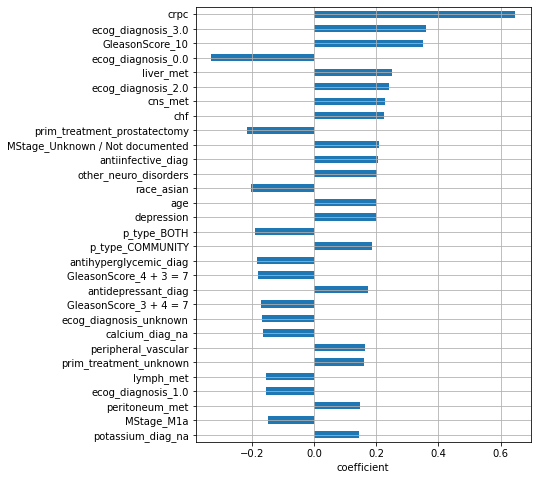

In [129]:
# Dataframe of coefficients for each variable 
coefficients_ridge = pd.DataFrame(
    ridge.named_steps['coxphsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_ridge.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_ridge.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

### 4.2 LASSO

In [130]:
lasso = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, alpha_min_ratio = 0.0001))

lasso.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope

In [131]:
estimated_alphas = lasso.named_steps['coxnetsurvivalanalysis'].alphas_

In [132]:
estimated_alphas

array([1.42234545e-01, 1.29598820e-01, 1.18085618e-01, 1.07595217e-01,
       9.80367546e-02, 8.93274395e-02, 8.13918360e-02, 7.41612096e-02,
       6.75729321e-02, 6.15699391e-02, 5.61002354e-02, 5.11164451e-02,
       4.65754010e-02, 4.24377707e-02, 3.86677161e-02, 3.52325828e-02,
       3.21026173e-02, 2.92507092e-02, 2.66521568e-02, 2.42844527e-02,
       2.21270888e-02, 2.01613792e-02, 1.83702979e-02, 1.67383312e-02,
       1.52513440e-02, 1.38964567e-02, 1.26619338e-02, 1.15370825e-02,
       1.05121598e-02, 9.57828854e-03, 8.72737979e-03, 7.95206342e-03,
       7.24562402e-03, 6.60194275e-03, 6.01544436e-03, 5.48104886e-03,
       4.99412758e-03, 4.55046305e-03, 4.14621246e-03, 3.77787437e-03,
       3.44225842e-03, 3.13645767e-03, 2.85782342e-03, 2.60394226e-03,
       2.37261521e-03, 2.16183861e-03, 1.96978683e-03, 1.79479639e-03,
       1.63535163e-03, 1.49007150e-03, 1.35769765e-03, 1.23708354e-03,
       1.12718444e-03, 1.02704848e-03, 9.35808328e-04, 8.52673695e-04,
      

In [133]:
pipe = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, max_iter = 100000))

# 5 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxnetsurvivalanalysis__alphas': [[x] for x in estimated_alphas]}

lasso_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
lasso_search.fit(train_x_red, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [134]:
lasso_search.best_params_

{'estimator__coxnetsurvivalanalysis__alphas': [0.004550463053759242]}

In [135]:
best_lasso_alpha = lasso_search.best_params_.get('estimator__coxnetsurvivalanalysis__alphas')

In [136]:
lasso_search_results = pd.DataFrame(lasso_search.cv_results_)

In [137]:
lasso_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
37,0.214207,0.016104,0.028480,0.006140,[0.004550463053759242],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.726267,0.729350,0.712863,0.736896,0.747505,0.730576,0.011492,1
36,0.206559,0.021956,0.029274,0.002812,[0.00499412758392253],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.725288,0.728670,0.712230,0.736441,0.746794,0.729885,0.011517,2
35,0.200960,0.012469,0.029436,0.004179,[0.005481048858069796],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.724180,0.727977,0.711820,0.736180,0.746077,0.729247,0.011509,3
34,0.183337,0.009427,0.035211,0.008291,[0.006015444355338726],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.722748,0.727023,0.711109,0.735591,0.745171,0.728329,0.011539,4
33,0.193316,0.013828,0.028189,0.004242,[0.006601942753876424],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.721071,0.725965,0.710407,0.735109,0.744197,0.727350,0.011597,5
32,0.184960,0.011074,0.026419,0.006502,[0.007245624022235202],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.718934,0.724829,0.709492,0.734377,0.743334,0.726193,0.011784,6
31,0.174622,0.012175,0.025719,0.003183,[0.007952063419629967],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.716540,0.723326,0.708409,0.733661,0.742169,0.724821,0.011994,7
30,0.187264,0.052855,0.024641,0.001774,[0.008727379786166379],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.713775,0.721596,0.707090,0.732768,0.740837,0.723213,0.012276,8
29,0.173151,0.013200,0.027305,0.005476,[0.009578288541306653],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.710687,0.719563,0.705645,0.731924,0.739021,0.721368,0.012551,9
28,0.159644,0.015642,0.026775,0.002532,[0.010512159849620336],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.708607,0.718354,0.703990,0.731180,0.737721,0.719970,0.012867,10


In [138]:
lasso = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 1.0, 
                                                               alphas = best_lasso_alpha,
                                                               max_iter = 100000))

lasso.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope

In [139]:
lasso_risk_scores_te = lasso.predict(test_x_red)
lasso_auc_te = cumulative_dynamic_auc(train_y, test_y, lasso_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', lasso_auc_te)

Test set AUC at 2 years: 0.7298043855095679


In [140]:
lasso_risk_scores_tr = lasso.predict(train_x_red)
lasso_auc_tr = cumulative_dynamic_auc(train_y, train_y, lasso_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', lasso_auc_tr)

Training set AUC at 2 years: 0.7341065424653899


In [141]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(lasso_risk_scores_te), len(lasso_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], lasso_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [142]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.009746708613411759


In [143]:
# Bootstrap 10000 3-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(lasso_risk_scores_tr), len(lasso_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], lasso_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [144]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.005027073451522494


In [145]:
crude_auc_data = {'model': 'lasso_crude',
                  'auc_2yr_te': lasso_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': lasso_auc_tr,
                  'sem_tr': standard_error_tr}

In [146]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [147]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [148]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.759629,0.009420,0.806806,0.004366
1,rsf_crude,0.752487,0.009532,0.841038,0.003831
2,ridge_crude,0.740313,0.009651,0.745116,0.004924
3,lasso_crude,0.729804,0.009747,0.734107,0.005027


In [149]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [150]:
times = np.arange(30, 1810, 30)
crude_lasso_auc_over5 = cumulative_dynamic_auc(train_y, test_y, lasso_risk_scores_te, times)[0]

times_data = {}
values = crude_lasso_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_lasso_over5_df = pd.DataFrame(times_data, index = ['lasso_crude'])

In [151]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [152]:
crude_auc_over5 = crude_auc_over5.append(crude_lasso_over5_df, ignore_index = False)

In [153]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.947724,0.880761,0.857184,0.850783,0.854125,0.846298,0.821203,0.826664,0.819633,0.815961,...,0.756552,0.755286,0.752378,0.754577,0.753897,0.752593,0.756331,0.756346,0.761979,0.758326
rsf_crude,0.918712,0.865238,0.844617,0.844055,0.847275,0.840756,0.820677,0.822317,0.814774,0.809029,...,0.751439,0.749241,0.747363,0.749141,0.750093,0.748249,0.752786,0.751592,0.754297,0.750243
ridge_crude,0.944066,0.858199,0.838196,0.838387,0.842047,0.827248,0.810477,0.811719,0.802155,0.797327,...,0.742487,0.740139,0.737662,0.737038,0.737439,0.737459,0.739872,0.739051,0.744756,0.742298
lasso_crude,0.934722,0.854081,0.819564,0.822334,0.825736,0.812310,0.793224,0.795675,0.785993,0.782356,...,0.736464,0.735302,0.731860,0.732927,0.733666,0.733052,0.737064,0.736304,0.742134,0.740127


In [154]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [155]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 200
Number of non-zero features in final model: 51


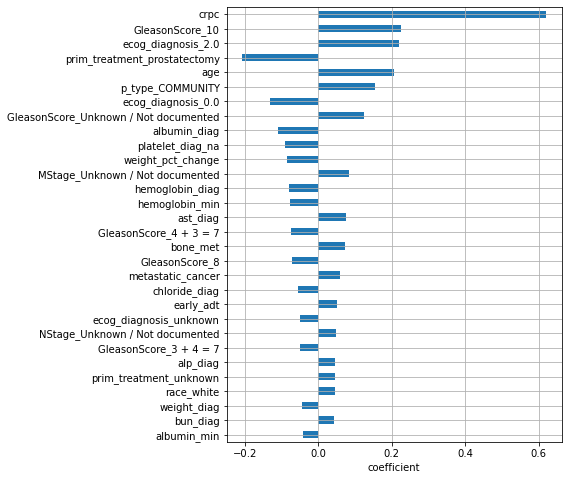

In [156]:
# Dataframe of coefficients for each variable 
coefficients_lasso = pd.DataFrame(
    lasso.named_steps['coxnetsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_lasso.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_lasso.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

### 4.3 Elastic net 

In [157]:
enet = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.8, alpha_min_ratio = 0.0001))

enet.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope

In [158]:
enet.named_steps['coxnetsurvivalanalysis'].alphas_

array([1.77793181e-01, 1.61998525e-01, 1.47607022e-01, 1.34494021e-01,
       1.22545943e-01, 1.11659299e-01, 1.01739795e-01, 9.27015120e-02,
       8.44661652e-02, 7.69624239e-02, 7.01252942e-02, 6.38955564e-02,
       5.82192512e-02, 5.30472134e-02, 4.83346452e-02, 4.40407285e-02,
       4.01282716e-02, 3.65633865e-02, 3.33151960e-02, 3.03555659e-02,
       2.76588610e-02, 2.52017241e-02, 2.29628724e-02, 2.09229141e-02,
       1.90641800e-02, 1.73705708e-02, 1.58274172e-02, 1.44213531e-02,
       1.31401998e-02, 1.19728607e-02, 1.09092247e-02, 9.94007927e-03,
       9.05703003e-03, 8.25242844e-03, 7.51930544e-03, 6.85131107e-03,
       6.24265948e-03, 5.68807882e-03, 5.18276557e-03, 4.72234296e-03,
       4.30282303e-03, 3.92057209e-03, 3.57227927e-03, 3.25492783e-03,
       2.96576901e-03, 2.70229826e-03, 2.46223353e-03, 2.24349549e-03,
       2.04418954e-03, 1.86258937e-03, 1.69712207e-03, 1.54635442e-03,
       1.40898055e-03, 1.28381061e-03, 1.16976041e-03, 1.06584212e-03,
      

In [159]:
estimated_alphas = enet.named_steps['coxnetsurvivalanalysis'].alphas_

In [160]:
pipe = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.9, max_iter = 100000))

# 5 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__coxnetsurvivalanalysis__alphas': [[x] for x in estimated_alphas]}

enet_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
enet_search.fit(train_x_red, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [161]:
enet_search.best_params_

{'estimator__coxnetsurvivalanalysis__alphas': [0.005182765572081219]}

In [162]:
best_enet_alpha = enet_search.best_params_.get('estimator__coxnetsurvivalanalysis__alphas')

In [163]:
enet_search_results = pd.DataFrame(enet_search.cv_results_)

In [164]:
enet_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__coxnetsurvivalanalysis__alphas,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
38,0.201672,0.023042,0.028801,0.004901,[0.005182765572081219],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.725846,0.729019,0.712714,0.736690,0.747358,0.730325,0.011511,1
37,0.197342,0.013036,0.030877,0.009507,[0.005688078817199051],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.724858,0.728459,0.712077,0.736451,0.746767,0.729722,0.011597,2
36,0.203833,0.012045,0.028706,0.004461,[0.006242659479903161],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.723704,0.727666,0.711627,0.736033,0.745890,0.728984,0.011545,3
35,0.178379,0.016122,0.029662,0.007240,[0.006851311072587242],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.722186,0.726704,0.710965,0.735481,0.745058,0.728079,0.011598,4
34,0.180991,0.011929,0.034058,0.006859,[0.007519305444173404],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.720421,0.725620,0.710097,0.734886,0.744077,0.727020,0.011702,5
33,0.175407,0.009632,0.027870,0.005210,[0.008252428442345527],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.718179,0.724368,0.709196,0.734150,0.743149,0.725809,0.011887,6
32,0.167557,0.009058,0.026074,0.004559,[0.009057030027794],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.715703,0.722774,0.708004,0.733495,0.741971,0.724389,0.012154,7
31,0.174009,0.018799,0.028867,0.004510,[0.009940079274537455],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.712861,0.720964,0.706722,0.732456,0.740397,0.722680,0.012357,8
30,0.166947,0.015544,0.026253,0.004741,[0.01090922473270797],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.710014,0.718912,0.705235,0.731703,0.738557,0.720884,0.012620,9
43,29.638888,58.815134,0.028271,0.006270,[0.0032549278267374887],{'estimator__coxnetsurvivalanalysis__alphas': ...,0.729834,0.732007,0.713749,0.674863,0.750195,0.720130,0.025413,10


In [165]:
enet = make_pipeline(preprocessor_red, CoxnetSurvivalAnalysis(l1_ratio = 0.8,
                                                              alphas = best_enet_alpha,
                                                              max_iter = 100000))

enet.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope

In [166]:
enet_risk_scores_te = enet.predict(test_x_red)
enet_auc_te = cumulative_dynamic_auc(train_y, test_y, enet_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', enet_auc_te)

Test set AUC at 2 years: 0.7306362468407598


In [167]:
enet_risk_scores_tr = enet.predict(train_x_red)
enet_auc_tr = cumulative_dynamic_auc(train_y, train_y, enet_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', enet_auc_tr)

Training set AUC at 2 years: 0.73475503370714


In [168]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(enet_risk_scores_te), len(enet_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], enet_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [169]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.009754957428173703


In [170]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(enet_risk_scores_tr), len(enet_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], enet_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [171]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.0050194025161311535


In [172]:
crude_auc_data = {'model': 'enet_crude',
                  'auc_2yr_te': enet_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': enet_auc_tr,
                  'sem_tr': standard_error_tr}

In [173]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [174]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [175]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.759629,0.009420,0.806806,0.004366
1,rsf_crude,0.752487,0.009532,0.841038,0.003831
2,ridge_crude,0.740313,0.009651,0.745116,0.004924
3,lasso_crude,0.729804,0.009747,0.734107,0.005027
4,enet_crude,0.730636,0.009755,0.734755,0.005019


In [176]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [177]:
times = np.arange(30, 1810, 30)
crude_enet_auc_over5 = cumulative_dynamic_auc(train_y, test_y, enet_risk_scores_te, times)[0]

times_data = {}
values = crude_enet_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_enet_over5_df = pd.DataFrame(times_data, index = ['enet_crude'])

In [178]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [179]:
crude_auc_over5 = crude_auc_over5.append(crude_enet_over5_df, ignore_index = False)

In [180]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.947724,0.880761,0.857184,0.850783,0.854125,0.846298,0.821203,0.826664,0.819633,0.815961,...,0.756552,0.755286,0.752378,0.754577,0.753897,0.752593,0.756331,0.756346,0.761979,0.758326
rsf_crude,0.918712,0.865238,0.844617,0.844055,0.847275,0.840756,0.820677,0.822317,0.814774,0.809029,...,0.751439,0.749241,0.747363,0.749141,0.750093,0.748249,0.752786,0.751592,0.754297,0.750243
ridge_crude,0.944066,0.858199,0.838196,0.838387,0.842047,0.827248,0.810477,0.811719,0.802155,0.797327,...,0.742487,0.740139,0.737662,0.737038,0.737439,0.737459,0.739872,0.739051,0.744756,0.742298
lasso_crude,0.934722,0.854081,0.819564,0.822334,0.825736,0.812310,0.793224,0.795675,0.785993,0.782356,...,0.736464,0.735302,0.731860,0.732927,0.733666,0.733052,0.737064,0.736304,0.742134,0.740127
enet_crude,0.935716,0.855639,0.821233,0.823948,0.826858,0.813310,0.794456,0.796794,0.787086,0.783311,...,0.737004,0.735793,0.732455,0.733473,0.734182,0.733602,0.737486,0.736721,0.742566,0.740589


In [181]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [182]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 200
Number of non-zero features in final model: 57


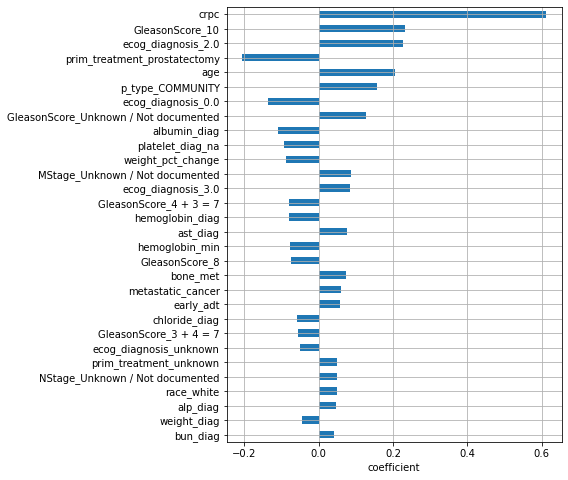

In [183]:
# Dataframe of coefficients for each variable 
coefficients_enet = pd.DataFrame(
    enet.named_steps['coxnetsurvivalanalysis'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_enet.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_enet.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

warnings.filterwarnings('ignore')

**Among the penalized Cox models, the ridge penalty has the best performance in regards to test set 2 year AUC. Not surprisingly, the penalized Cox models perform worse than the gradient boosting model or the random survival forest.**

## 5. Linear survival support vector machine 

**Lastly, we'll build a survival support vector machines with a linear kernel and a ranking objective.** 

In [184]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline

from sksurv.svm import FastSurvivalSVM
from sksurv.metrics import cumulative_dynamic_auc, as_cumulative_dynamic_auc_scorer

import warnings 

import matplotlib.pyplot as plt

In [185]:
pipe = make_pipeline(preprocessor_red, FastSurvivalSVM(rank_ratio = 1, 
                                                       max_iter = 1000, 
                                                       tol = 1e-3,
                                                       random_state = 42))

# 3 fold cross-validation
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Parameter gird 
param_grid = {'estimator__fastsurvivalsvm__alpha': 10. ** np.linspace(-3, 3, 15)}

linear_svm_search = GridSearchCV(
    as_cumulative_dynamic_auc_scorer(pipe, 730),
    param_grid = param_grid,
    cv = cv,
    error_score = 0.5,
    n_jobs = -1,
    refit = False)

# Run search 
warnings.filterwarnings('ignore')
linear_svm_search.fit(train_x_red, train_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=0.5,
             estimator=as_cumulative_dynamic_auc_scorer(estimator=Pipeline(steps=[('columntransformer',
                                                                                   ColumnTransformer(remainder='passthrough',
                                                                                                     transformers=[('num',
                                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                                     SimpleImputer(strategy='median')),
                                                                                                                                    ('std_scaler',
                                                                                  

In [186]:
linear_svm_search.best_params_

{'estimator__fastsurvivalsvm__alpha': 0.13894954943731375}

In [187]:
best_linear_svm_alpha = linear_svm_search.best_params_.get('estimator__fastsurvivalsvm__alpha')

In [188]:
linear_svm_search_results = pd.DataFrame(linear_svm_search.cv_results_)

In [189]:
linear_svm_search_results.sort_values(by = 'rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__fastsurvivalsvm__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,46.712372,11.876838,0.030220,0.002630,0.13895,{'estimator__fastsurvivalsvm__alpha': 0.138949...,0.733077,0.731871,0.718096,0.741132,0.749852,0.734805,0.010557,1
10,42.357087,11.348175,0.027203,0.006116,19.306977,{'estimator__fastsurvivalsvm__alpha': 19.30697...,0.733077,0.731855,0.718062,0.741136,0.749885,0.734803,0.010578,2
14,39.462178,10.086072,0.021376,0.000500,1000.0,{'estimator__fastsurvivalsvm__alpha': 1000.0},0.733072,0.731835,0.718090,0.741126,0.749876,0.734800,0.010567,3
8,44.187032,9.530277,0.026346,0.003977,2.682696,{'estimator__fastsurvivalsvm__alpha': 2.682695...,0.733080,0.731847,0.718086,0.741140,0.749842,0.734799,0.010559,4
12,45.474928,11.254117,0.030494,0.004298,138.949549,{'estimator__fastsurvivalsvm__alpha': 138.9495...,0.733070,0.731833,0.718086,0.741123,0.749866,0.734796,0.010565,5
9,45.673889,10.619440,0.029288,0.006902,7.196857,{'estimator__fastsurvivalsvm__alpha': 7.196856...,0.733079,0.731847,0.718086,0.741120,0.749836,0.734794,0.010555,6
6,43.568488,9.964913,0.030912,0.003121,0.372759,{'estimator__fastsurvivalsvm__alpha': 0.372759...,0.733086,0.731846,0.718089,0.741108,0.749831,0.734792,0.010551,7
3,43.626350,10.982265,0.027330,0.003788,0.019307,{'estimator__fastsurvivalsvm__alpha': 0.019306...,0.733080,0.731814,0.718078,0.741122,0.749850,0.734789,0.010564,8
2,42.718872,9.868054,0.028922,0.004185,0.007197,{'estimator__fastsurvivalsvm__alpha': 0.007196...,0.733058,0.731767,0.718108,0.741136,0.749847,0.734783,0.010558,9
7,42.908771,15.519783,0.026866,0.004269,1.0,{'estimator__fastsurvivalsvm__alpha': 1.0},0.733073,0.731860,0.718091,0.741149,0.749742,0.734783,0.010530,10


In [190]:
linear_svm = make_pipeline(preprocessor_red, FastSurvivalSVM(alpha = best_linear_svm_alpha,
                                                             rank_ratio = 1,
                                                             max_iter = 1000,
                                                             tol = 1e-3,
                                                             random_state = 42))

linear_svm.fit(train_x_red, train_y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'PSADiagnosis',
                                                   'PSAMetDiagnosis',
                                                   'delta_met_diagnosis',
                                                   'crpc_time', 'weight_diag',
                                                   'bmi_diag',
                                                   'weight_pct_change',
                                                   'weight_slope

In [191]:
linear_svm_risk_scores_te = linear_svm.predict(test_x_red)
linear_svm_auc_te = cumulative_dynamic_auc(train_y, test_y, linear_svm_risk_scores_te, 730)[0][0]
print('Test set AUC at 2 years:', linear_svm_auc_te)

Test set AUC at 2 years: 0.7414711849286247


In [192]:
linear_svm_risk_scores_tr = linear_svm.predict(train_x_red)
linear_svm_auc_tr = cumulative_dynamic_auc(train_y, train_y, linear_svm_risk_scores_tr, 730)[0][0]
print('Training set AUC at 2 years:', linear_svm_auc_tr)

Training set AUC at 2 years: 0.7486654228647115


In [193]:
# Bootstrap 10000 2-yr AUCs for test set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_te = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(linear_svm_risk_scores_te), len(linear_svm_risk_scores_te))
    auc_yr = cumulative_dynamic_auc(train_y, test_y[indices], linear_svm_risk_scores_te[indices], 730)[0][0]
    bootstrapped_scores_te.append(auc_yr)

In [194]:
# Standard error of mean for test set AUC
sorted_scores_te = np.array(bootstrapped_scores_te)
sorted_scores_te.sort()

conf_lower_te = sorted_scores_te[int(0.025 * len(sorted_scores_te))]
conf_upper_te = sorted_scores_te[int(0.975 * len(sorted_scores_te))]

standard_error_te = (conf_upper_te - conf_lower_te) / 3.92
print('Test set AUC standard error:', standard_error_te)

Test set AUC standard error: 0.009655793816769597


In [195]:
# Bootstrap 10000 2-yr AUCs for train set 
n_bootstraps = 10000
rng_seed = 42 
bootstrapped_scores_tr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(linear_svm_risk_scores_tr), len(linear_svm_risk_scores_tr))
    auc_yr = cumulative_dynamic_auc(train_y, train_y[indices], linear_svm_risk_scores_tr[indices], 730)[0][0]
    bootstrapped_scores_tr.append(auc_yr)

In [196]:
# Standard error of mean for train set AUC
sorted_scores_tr = np.array(bootstrapped_scores_tr)
sorted_scores_tr.sort()

conf_lower_tr = sorted_scores_tr[int(0.025 * len(sorted_scores_tr))]
conf_upper_tr = sorted_scores_tr[int(0.975 * len(sorted_scores_tr))]

standard_error_tr = (conf_upper_tr - conf_lower_tr) / 3.92
print('Training set AUC standard error', standard_error_tr)

Training set AUC standard error 0.004838010559009768


In [197]:
crude_auc_data = {'model': 'linear_svm_crude',
                  'auc_2yr_te': linear_svm_auc_te,
                  'sem_te': standard_error_te,
                  'auc_2yr_tr': linear_svm_auc_tr,
                  'sem_tr': standard_error_tr}

In [198]:
crude_auc_df = pd.read_csv('crude_auc_df.csv')

In [199]:
crude_auc_df = crude_auc_df.append(crude_auc_data, ignore_index = True)

In [200]:
crude_auc_df

,model,auc_2yr_te,sem_te,auc_2yr_tr,sem_tr
0,gbm_crude,0.759629,0.009420,0.806806,0.004366
1,rsf_crude,0.752487,0.009532,0.841038,0.003831
2,ridge_crude,0.740313,0.009651,0.745116,0.004924
3,lasso_crude,0.729804,0.009747,0.734107,0.005027
4,enet_crude,0.730636,0.009755,0.734755,0.005019
5,linear_svm_crude,0.741471,0.009656,0.748665,0.004838


In [201]:
crude_auc_df.to_csv('crude_auc_df.csv', index = False, header = True)

In [202]:
times = np.arange(30, 1810, 30)
crude_linear_svm_auc_over5 = cumulative_dynamic_auc(train_y, test_y, linear_svm_risk_scores_te, times)[0]

times_data = {}
values = crude_linear_svm_auc_over5
time_names = []

for x in range(len(times)):
    time_names.append('time_'+str(times[x]))

for i in range(len(time_names)):
    times_data[time_names[i]] = values[i]
    
crude_linear_svm_over5_df = pd.DataFrame(times_data, index = ['linear_svm_crude'])

In [203]:
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

In [204]:
crude_auc_over5 = crude_auc_over5.append(crude_linear_svm_over5_df, ignore_index = False)

In [205]:
crude_auc_over5

,time_30,time_60,time_90,time_120,time_150,time_180,time_210,time_240,time_270,time_300,...,time_1530,time_1560,time_1590,time_1620,time_1650,time_1680,time_1710,time_1740,time_1770,time_1800
gbm_crude,0.947724,0.880761,0.857184,0.850783,0.854125,0.846298,0.821203,0.826664,0.819633,0.815961,...,0.756552,0.755286,0.752378,0.754577,0.753897,0.752593,0.756331,0.756346,0.761979,0.758326
rsf_crude,0.918712,0.865238,0.844617,0.844055,0.847275,0.840756,0.820677,0.822317,0.814774,0.809029,...,0.751439,0.749241,0.747363,0.749141,0.750093,0.748249,0.752786,0.751592,0.754297,0.750243
ridge_crude,0.944066,0.858199,0.838196,0.838387,0.842047,0.827248,0.810477,0.811719,0.802155,0.797327,...,0.742487,0.740139,0.737662,0.737038,0.737439,0.737459,0.739872,0.739051,0.744756,0.742298
lasso_crude,0.934722,0.854081,0.819564,0.822334,0.825736,0.812310,0.793224,0.795675,0.785993,0.782356,...,0.736464,0.735302,0.731860,0.732927,0.733666,0.733052,0.737064,0.736304,0.742134,0.740127
enet_crude,0.935716,0.855639,0.821233,0.823948,0.826858,0.813310,0.794456,0.796794,0.787086,0.783311,...,0.737004,0.735793,0.732455,0.733473,0.734182,0.733602,0.737486,0.736721,0.742566,0.740589
linear_svm_crude,0.941728,0.859325,0.838551,0.839156,0.843990,0.829755,0.814317,0.814397,0.806246,0.800611,...,0.740246,0.737412,0.735162,0.734755,0.734975,0.734682,0.737810,0.735738,0.741298,0.738656


In [206]:
crude_auc_over5.to_csv('crude_auc_over5.csv', index = True, header = True)

In [207]:
# Variables passing through pipeline
cat_encoder = list(preprocessor_red.transformers_[1][1].get_feature_names_out(categorical_features))
pass_through = list(train_x_red.iloc[:, preprocessor_red.transformers_[2][2]].columns)
attributes = numerical_features_red + cat_encoder + pass_through

Total number of features: 200
Number of non-zero features in final model: 200


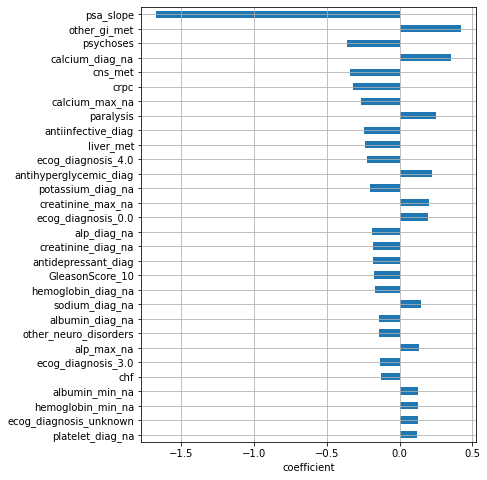

/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/py

/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: all coefficients are zero, consider decreasing alpha.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [208]:
# Dataframe of coefficients for each variable 
coefficients_linear_svm = pd.DataFrame(
    linear_svm.named_steps['fastsurvivalsvm'].coef_,
    index = attributes,
    columns = ['coefficient']
)

print('Total number of features: {}'.format(len(attributes)))

non_zero = np.sum(coefficients_linear_svm.iloc[:, 0] != 0)
print('Number of non-zero features in final model: {}'.format(non_zero))

non_zero_coefs = coefficients_linear_svm.query('coefficient != 0')
coef_order = non_zero_coefs.abs().sort_values('coefficient').tail(30).index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax = ax, legend = False)
ax.set_xlabel('coefficient')
ax.grid(True)

**In conclusion, the gradient boosted model has the best test set performance in regards to 2 year AUC. Random survival forest follows closely behind. The bottom performers are penalized Cox and linear survival support vector machine.** 